In [89]:
#First, we set the seeds which will help us to reproroduce our results in the future.

import numpy as np
import tensorflow as tf
import functools
import random as rn
import warnings
import sys
warnings.filterwarnings("ignore")
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
import os
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import multiprocessing
import time
import pickle
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils.io_utils import HDF5Matrix
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, MaxPooling2D, AveragePooling2D, ZeroPadding2D,Dropout, Flatten, Reshape, Activation,BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Dropout, merge, Lambda, GlobalAveragePooling2D, Merge
from keras import layers
from keras.models import Model
from keras.initializers import glorot_uniform
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from keras.applications import InceptionV3
import seaborn as sns
from collections import Counter

In [4]:
os.chdir("D:/Python/extras")

In [5]:
train_dataset=pd.read_csv("animal_attributes/meta-data/train.csv") 

In [6]:
image_list=list(train_dataset["Image_name"])

<br>
<br>
We first shuffle the dataset and split it into train and validation set. Next, we save both the list of image names as pickle file so that we can get the same partition of the dataset in the future.
<br>
<br>

In [7]:
labels=dict()

In [8]:
for i in image_list:
    labels[i]=train_dataset.loc[train_dataset['Image_name'] == i].get_values()[0][1:].astype(int)

In [9]:
with open("animal_attributes/validation_dataset.pkl", 'rb') as pickle_file:
    validation=pickle.load(pickle_file)

In [10]:
with open("animal_attributes/train_dataset.pkl", 'rb') as pickle_file:
    train=pickle.load(pickle_file)

<br>
<br>
The below plot is of the number of images per attribute. The attributes are arranged with increasing order of the number of images for that particular attribute. From the plot, we can conclude that the data distribution is highly unbalanced.
<br>
<br>

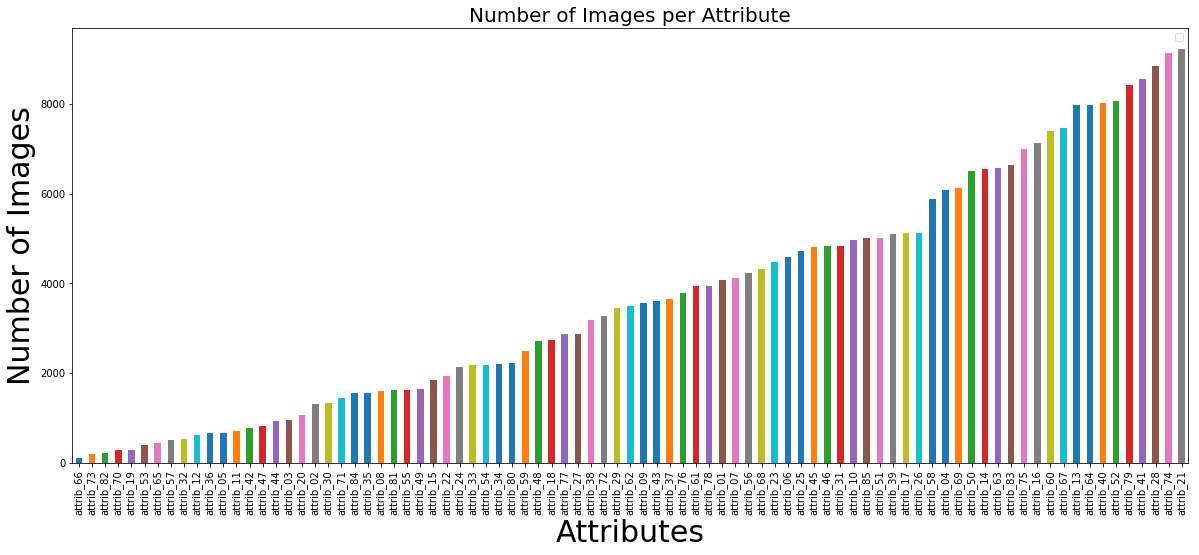

In [99]:
plt.figure(figsize=(20,8))
train_dataset.loc[train_dataset['Image_name'].isin(train)].sum()[1:].sort_values().plot("bar")
plt.xlabel("Attributes",fontsize=30)
plt.ylabel("Number of Images",fontsize=30)
plt.title("Number of Images per Attribute",fontsize=20)
plt.legend("")
plt.show()

The dataset consists of 12600 images- we split it into train and validation set in the ratio 10100:2500. To avoid overfitting we augment the images, it helps us to train our model on a larger dataset making it more reliable.

We perform the following augmentations,<br>
i) Rotate the images by not more than 20 degree.<br>
ii) Shift the images slighty.<br>
iii) Flip the images horizontally<br>
iv) Alter values of the RGB pixels of the images using customized function<br>

In [12]:
def myFunc(image):
    status=np.random.randint(0,2)
    if status==0:
        return np.array(cv2.merge((cv2.split(image)[0]*np.random.randint(5,11)/10,cv2.split(image)[1]*np.random.randint(5,10)/10,
                          cv2.split(image)[2]*np.random.randint(5,10)/10)))
    else:
        return image

In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,preprocessing_function=myFunc)

<br>Next, we build generator functions(to avoid loading the whole dataset on memory) that loads images in batches directly from the folder and feeds the mini batches to the model for training.
<br>
<br>

In [14]:
def generator(partition,labels,batch_size):
    
    """
    
    Loads the images from the directory and forms mini-batches
    to feed the model directly.
    
    """
    
    while 1:
        for i in range(0,len(partition),batch_size):
            if (i+batch_size)<len(partition):
                X_train=np.zeros([batch_size,224,224,3])
                y_train=np.zeros([batch_size,85])
                for j in range(0,batch_size):
                    X_train[j]=np.array(load_img("animal_attributes/train_img/"+partition[i+j],target_size=(224,224,3)))/255.
                    y_train[j]=labels[partition[i+j]].reshape(1,85)
                yield X_train,y_train
        else:
            batch_size=len(partition)-i
            X_train=np.zeros([batch_size,224,224,3])
            y_train=np.zeros([batch_size,85])
            for j in range(0,batch_size):
                X_train[j]=np.array(load_img("animal_attributes/train_img/"+partition[i+j],target_size=(224,224,3)))/255.
                y_train[j]=labels[partition[i+j]].reshape(1,85)
            yield X_train,y_train

In [16]:
def test_generator(partition,batch_size):
    
    """
    Used for generating mini-batches of test data.
    
    Loads the images from the test images directory and forms mini-batches
    to feed the model.
    
    """
    
    
    while 1:
        for i in range(0,len(partition),batch_size):
            if (i+batch_size)<len(partition):
                X_train=np.zeros([batch_size,224,224,3])
                for j in range(0,batch_size):
                    X_train[j]=np.array(load_img("animal_attributes/test_img/"+partition[i+j],target_size=(224,224,3)))/255.
                yield X_train
            else:
                batch_size=len(partition)-i
                X_train=np.zeros([batch_size,224,224,3])
                for j in range(0,batch_size):
                    X_train[j]=np.array(load_img("animal_attributes/test_img/"+partition[i+j],target_size=(224,224,3)))/255.
                yield X_train

In [17]:
def pickle_gen(directory="animal_attributes/train_numpy16/"):
    
    """
    
    The mini-batches of training images are already saved in the directory
    in the pickle format.
    
    This generator function loads these mini-batches and feeds directly to the 
    model.
    
    """
    while 1:
        for i in os.listdir(directory):
            with open(directory+i, 'rb') as pickle_file:
                yield pickle.load(pickle_file)

In [18]:
def f1(y_true, y_pred):
    y_true=tf.reshape(y_true,[-1,85])
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Inception V3 Model with batch size 16 

In [18]:
checkpointer = ModelCheckpoint(filepath='animal_attributes/weights/InceptionV3_batch16/'+'sgd_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False)

In [72]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output

x = keras.layers.GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

output_model = Dense(85, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output_model)

model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy',f1])

In [20]:
model.fit_generator(generator=pickle_gen("animal_attributes/train_numpy16/"),steps_per_epoch=2650,verbose = 1,epochs=15,validation_data=generator(partition=validation,labels=labels,batch_size=16),validation_steps=157,callbacks=[checkpointer])

Epoch 1/15
2650/2650 [==============================] - 1449s 547ms/step - loss: 0.4018 - acc: 0.8183 - f1: 0.7361 - val_loss: 0.2401 - val_acc: 0.9121 - val_f1: 0.8758

Epoch 00001: saving model to animal_attributes/weights/InceptionV3_batch16/sgd_weights.01-0.24.hdf5
Epoch 2/15
2650/2650 [==============================] - 10845s 4s/step - loss: 0.2289 - acc: 0.9125 - f1: 0.8776 - val_loss: 0.1440 - val_acc: 0.9471 - val_f1: 0.9266

Epoch 00002: saving model to animal_attributes/weights/InceptionV3_batch16/sgd_weights.02-0.14.hdf5
Epoch 3/15
2650/2650 [==============================] - 972s 367ms/step - loss: 0.1616 - acc: 0.9417 - f1: 0.9191 - val_loss: 0.1148 - val_acc: 0.9577 - val_f1: 0.9412

Epoch 00003: saving model to animal_attributes/weights/InceptionV3_batch16/sgd_weights.03-0.11.hdf5
Epoch 4/15
2650/2650 [==============================] - 977s 369ms/step - loss: 0.1210 - acc: 0.9588 - f1: 0.9431 - val_loss: 0.0955 - val_acc: 0.9652 - val_f1: 0.9516

Epoch 00004: saving mode

In [21]:
model.fit_generator(generator=pickle_gen("animal_attributes/train_numpy16/"),steps_per_epoch=2650,verbose = 1,epochs=20,initial_epoch=15,validation_data=generator(partition=validation,labels=labels,batch_size=16),validation_steps=157,callbacks=[checkpointer])

Epoch 16/20
2650/2650 [==============================] - 1067s 403ms/step - loss: 0.0109 - acc: 0.9990 - f1: 0.9986 - val_loss: 0.0808 - val_acc: 0.9756 - val_f1: 0.9664

Epoch 00016: saving model to animal_attributes/weights/InceptionV3_batch16/sgd_weights.16-0.08.hdf5
Epoch 17/20
2650/2650 [==============================] - 985s 372ms/step - loss: 0.0097 - acc: 0.9992 - f1: 0.9989 - val_loss: 0.0883 - val_acc: 0.9740 - val_f1: 0.9647

Epoch 00017: saving model to animal_attributes/weights/InceptionV3_batch16/sgd_weights.17-0.09.hdf5
Epoch 18/20
2650/2650 [==============================] - 985s 372ms/step - loss: 0.0086 - acc: 0.9993 - f1: 0.9991 - val_loss: 0.0873 - val_acc: 0.9748 - val_f1: 0.9654

Epoch 00018: saving model to animal_attributes/weights/InceptionV3_batch16/sgd_weights.18-0.09.hdf5
Epoch 19/20
2650/2650 [==============================] - 988s 373ms/step - loss: 0.0078 - acc: 0.9994 - f1: 0.9992 - val_loss: 0.0928 - val_acc: 0.9738 - val_f1: 0.9637

Epoch 00019: saving

In [71]:
del model

# Inception V3 Model with batch size 32

In [25]:
checkpointer = ModelCheckpoint(filepath='animal_attributes/weights/InceptionV3_batch32/'+'sgd_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False)

In [19]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output

x = keras.layers.GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

output_model = Dense(85, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output_model)

model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy',f1])

In [27]:
model.fit_generator(generator=pickle_gen("animal_attributes/train_numpy32/"),steps_per_epoch=1325,verbose = 1,epochs=15,validation_data=generator(partition=validation,labels=labels,batch_size=32),validation_steps=79,callbacks=[checkpointer])

Epoch 1/15
1325/1325 [==============================] - 1194s 901ms/step - loss: 0.4670 - acc: 0.7784 - f1: 0.6765 - val_loss: 0.3491 - val_acc: 0.8566 - val_f1: 0.7928

Epoch 00001: saving model to animal_attributes/weights/InceptionV3_batch32/sgd_weights.01-0.35.hdf5
Epoch 2/15
1325/1325 [==============================] - 804s 607ms/step - loss: 0.3036 - acc: 0.8799 - f1: 0.8290 - val_loss: 0.2221 - val_acc: 0.9206 - val_f1: 0.8886

Epoch 00002: saving model to animal_attributes/weights/InceptionV3_batch32/sgd_weights.02-0.22.hdf5
Epoch 3/15
1325/1325 [==============================] - 806s 608ms/step - loss: 0.2148 - acc: 0.9217 - f1: 0.8906 - val_loss: 0.1601 - val_acc: 0.9448 - val_f1: 0.9233

Epoch 00003: saving model to animal_attributes/weights/InceptionV3_batch32/sgd_weights.03-0.16.hdf5
Epoch 4/15
1325/1325 [==============================] - 807s 609ms/step - loss: 0.1676 - acc: 0.9411 - f1: 0.9182 - val_loss: 0.1280 - val_acc: 0.9561 - val_f1: 0.9392

Epoch 00004: saving mod

In [28]:
model.fit_generator(generator=pickle_gen("animal_attributes/train_numpy32/"),steps_per_epoch=1325,verbose = 1,epochs=20,initial_epoch=15,validation_data=generator(partition=validation,labels=labels,batch_size=32),validation_steps=79,callbacks=[checkpointer])

Epoch 16/20
1325/1325 [==============================] - 918s 693ms/step - loss: 0.0267 - acc: 0.9952 - f1: 0.9934 - val_loss: 0.0750 - val_acc: 0.9738 - val_f1: 0.9639

Epoch 00016: saving model to animal_attributes/weights/InceptionV3_batch32/sgd_weights.16-0.07.hdf5
Epoch 17/20
1325/1325 [==============================] - 806s 609ms/step - loss: 0.0237 - acc: 0.9960 - f1: 0.9945 - val_loss: 0.0857 - val_acc: 0.9724 - val_f1: 0.9625

Epoch 00017: saving model to animal_attributes/weights/InceptionV3_batch32/sgd_weights.17-0.09.hdf5
Epoch 18/20
1325/1325 [==============================] - 810s 612ms/step - loss: 0.0211 - acc: 0.9967 - f1: 0.9955 - val_loss: 0.0675 - val_acc: 0.9750 - val_f1: 0.9661

Epoch 00018: saving model to animal_attributes/weights/InceptionV3_batch32/sgd_weights.18-0.07.hdf5
Epoch 19/20
1325/1325 [==============================] - 808s 610ms/step - loss: 0.0189 - acc: 0.9972 - f1: 0.9961 - val_loss: 0.0732 - val_acc: 0.9753 - val_f1: 0.9661

Epoch 00019: saving 

In [29]:
del model

# Inception V3 Model with batch size 16(Extra Images) 

<br>After error analysis of the predictions of the model on validation and train dataset, the conclusion was that the model predictions were poor on images of pigs and german shepherd. This was not suprising given the small number of the images of pigs and germam shepherds in the dataset. So, we added extra images to the dataset to tackle this problem.
<br>

In [30]:
checkpointer = ModelCheckpoint(filepath='animal_attributes/weights/InceptionV3_batch16_extra/'+'sgd_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False)

In [31]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output

x = keras.layers.GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

output_model = Dense(85, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output_model)

model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy',f1])

In [32]:
model.fit_generator(generator=pickle_gen("animal_attributes/train_numpy16_extra/"),steps_per_epoch=2702,verbose = 1,epochs=10,validation_data=generator(partition=validation,labels=labels,batch_size=16),validation_steps=157,callbacks=[checkpointer])

Epoch 1/10
2702/2702 [==============================] - 1095s 405ms/step - loss: 0.3983 - acc: 0.8203 - f1: 0.7411 - val_loss: 0.2487 - val_acc: 0.9068 - val_f1: 0.8681

Epoch 00001: saving model to animal_attributes/weights/InceptionV3_batch16_extra/sgd_weights.01-0.25.hdf5
Epoch 2/10
2702/2702 [==============================] - 993s 367ms/step - loss: 0.2285 - acc: 0.9128 - f1: 0.8781 - val_loss: 0.1598 - val_acc: 0.9404 - val_f1: 0.9174

Epoch 00002: saving model to animal_attributes/weights/InceptionV3_batch16_extra/sgd_weights.02-0.16.hdf5
Epoch 3/10
2702/2702 [==============================] - 991s 367ms/step - loss: 0.1632 - acc: 0.9412 - f1: 0.9186 - val_loss: 0.1295 - val_acc: 0.9506 - val_f1: 0.9312

Epoch 00003: saving model to animal_attributes/weights/InceptionV3_batch16_extra/sgd_weights.03-0.13.hdf5
Epoch 4/10
2702/2702 [==============================] - 996s 369ms/step - loss: 0.1232 - acc: 0.9579 - f1: 0.9419 - val_loss: 0.1080 - val_acc: 0.9608 - val_f1: 0.9453

Epoch

# Resnet Model

In [18]:
checkpointer = ModelCheckpoint(filepath='animal_attributes/weights/resnet/'+'resnet_sgd_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=False)

In [30]:
sys.setrecursionlimit(3000)

def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a', bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a', scale=True, beta_initializer='zeros', gamma_initializer='ones')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      name=conv_name_base + '2b', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b', scale=True, beta_initializer='zeros', gamma_initializer='ones')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c', scale=True, beta_initializer='zeros', gamma_initializer='ones')(x)

    x = merge([x, input_tensor], mode='sum', name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a', bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a', scale=True, beta_initializer='zeros', gamma_initializer='ones')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      name=conv_name_base + '2b', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b', scale=True, beta_initializer='zeros', gamma_initializer='ones')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c', scale=True, beta_initializer='zeros', gamma_initializer='ones')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1', bias=False)(input_tensor)
    shortcut = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum', name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

In [31]:
def resnet101_model(weights_path=None):
    '''Instantiate the ResNet101 architecture,
    # Arguments
        weights_path: path to pretrained weight file
    # Returns
        A Keras model instance.
    '''
    eps = 1.1e-5

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
        img_input = Input(shape=(224, 224, 3), name='data')
    else:
        bn_axis = 1
        img_input = Input(shape=(3, 224, 224), name='data')

    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name='bn_conv1', scale=True, beta_initializer='zeros', gamma_initializer='ones')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1,3):
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='b'+str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1,23):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b'+str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_model = Dense(85, activation='sigmoid')(x)

    model = Model(img_input,output_model)
    
    # load weights
    if weights_path:
        model.load_weights(weights_path, by_name=True)

    return model

In [32]:
model=resnet101_model(weights_path="resnet101_weights_tf.h5")

In [33]:
model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy',f1])

In [23]:
model.fit_generator(generator=pickle_gen("animal_attributes/train_numpy13/"),steps_per_epoch=3261,verbose = 1,epochs=10,validation_data=generator(partition=validation,labels=labels,batch_size=16),validation_steps=157,callbacks=[checkpointer])

Epoch 1/10
3261/3261 [==============================] - 2349s 720ms/step - loss: 0.4213 - acc: 0.7986 - f1: 0.7119 - val_loss: 0.3691 - val_acc: 0.8298 - val_f1: 0.7575

Epoch 00001: saving model to animal_attributes/weights/resnet/resnet_sgd_weights.01-0.37.hdf5
Epoch 2/10
3261/3261 [==============================] - 2136s 655ms/step - loss: 0.3218 - acc: 0.8568 - f1: 0.7987 - val_loss: 0.3098 - val_acc: 0.8608 - val_f1: 0.8064

Epoch 00002: saving model to animal_attributes/weights/resnet/resnet_sgd_weights.02-0.31.hdf5
Epoch 3/10
3261/3261 [==============================] - 2143s 657ms/step - loss: 0.2477 - acc: 0.8945 - f1: 0.8531 - val_loss: 0.2964 - val_acc: 0.8734 - val_f1: 0.8217

Epoch 00003: saving model to animal_attributes/weights/resnet/resnet_sgd_weights.03-0.30.hdf5
Epoch 4/10
3261/3261 [==============================] - 2145s 658ms/step - loss: 0.1880 - acc: 0.9226 - f1: 0.8928 - val_loss: 0.2731 - val_acc: 0.8883 - val_f1: 0.8439

Epoch 00004: saving model to animal_at

# Ensemble

In [73]:
model.load_weights("animal_attributes\weights\InceptionV3_batch32\sgd_weights.11-0.07.hdf5")

In [21]:
inception_32=(model.predict_generator(generator=generator(partition=validation,labels=labels,batch_size=32),steps=79)>.5).astype(int)

In [76]:
model.load_weights("animal_attributes\weights\InceptionV3_batch16\sgd_weights.20-0.07.hdf5")

In [25]:
prediction_best=(model.predict_generator(generator=generator(partition=validation,labels=labels,batch_size=16),steps=157)>.5).astype(int)

In [78]:
model.load_weights("animal_attributes/weights/InceptionV3_batch16_extra/sgd_weights.09-0.09.hdf5")

In [27]:
inception_extra=(model.predict_generator(generator=generator(partition=validation,labels=labels,batch_size=16),steps=157)>.5).astype(int)

In [28]:
del model

In [34]:
model.load_weights("animal_attributes/weights/resnet/resnet_sgd_weights.08-0.26.hdf5")

In [35]:
resnet=(model.predict_generator(generator=generator(partition=validation,labels=labels,batch_size=13),steps=193)>.5).astype(int)

In [39]:
train_predictions=((.4*prediction_best+.4*inception_32+.2*inception_extra+.2*resnet)>.5).astype(int)

In [68]:
final_train_score=[f1_score([labels[i] for i in validation][j],train_predictions[j]) for j in range(len(train_predictions))]

In [69]:
np.mean(final_train_score)

0.9659921280733977

# Predictions

In [77]:
inception_16_test=(model.predict_generator(generator=test_generator(partition=os.listdir("animal_attributes/test_img"),batch_size=16),steps=338)>.5).astype(int)

In [75]:
inception_32_test=(model.predict_generator(generator=test_generator(partition=os.listdir("animal_attributes/test_img"),batch_size=16),steps=338)>.5).astype(int)

In [79]:
inception_extra_test=(model.predict_generator(generator=test_generator(partition=os.listdir("animal_attributes/test_img"),batch_size=16),steps=338)>.5).astype(int)

In [70]:
resnet_test=(model.predict_generator(generator=test_generator(partition=os.listdir("animal_attributes/test_img"),batch_size=16),steps=338)>.5).astype(int)

In [80]:
pred_dict=dict()

In [81]:
predictions=((inception_16_test*.4+inception_32_test*.4+resnet_test*.2+inception_extra_test*.2)>.5).astype(int)

In [82]:
for j,i in enumerate(os.listdir("animal_attributes/test_img")):
    pred_dict[i]=predictions[j]

In [83]:
test_df=pd.read_csv("animal_attributes/meta-data/sample_submission.csv")

In [84]:
submit=pd.DataFrame(columns=test_df.columns)

In [85]:
submit["Image_name"]=test_df.Image_name

In [86]:
for i in range(len(test_df)):
    submit.loc[i][1:]=pred_dict[submit.loc[i][0]]

In [87]:
submit.to_csv("animal_attributes/final_submission.csv",index=None)

In [88]:
submit

,Image_name,attrib_01,attrib_02,attrib_03,attrib_04,attrib_05,attrib_06,attrib_07,attrib_08,attrib_09,...,attrib_76,attrib_77,attrib_78,attrib_79,attrib_80,attrib_81,attrib_82,attrib_83,attrib_84,attrib_85
0,Image-1.jpg,0,0,0,0,0,1,0,0,1,...,0,0,0,1,1,0,0,1,0,1
1,Image-2.jpg,0,1,0,0,0,1,1,0,0,...,0,1,0,1,0,0,0,0,1,1
2,Image-3.jpg,0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1
3,Image-4.jpg,1,0,0,0,1,1,1,0,0,...,0,1,1,1,0,0,0,0,0,1
4,Image-5.jpg,0,0,0,1,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0
5,Image-6.jpg,1,0,1,1,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
6,Image-7.jpg,0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1
7,Image-8.jpg,0,0,0,1,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0
8,Image-9.jpg,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,1,0,1
9,Image-10.jpg,0,0,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,1
